In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [3]:
### 加载数据并对数据进行预处理
# 1. 加载数据
path = "datas/crx.data"
names = ['A1','A2','A3','A4','A5','A6','A7','A8',
         'A9','A10','A11','A12','A13','A14','A15','A16']
df = pd.read_csv(path, header=None, names=names)
print ("数据条数:", len(df))

# 2. 异常数据过滤
df = df.replace("?", np.nan).dropna(how='any')
print ("过滤后数据条数:", len(df))

df.head(5)

数据条数: 690
过滤后数据条数: 653


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [28]:


def parse(v, l):
    return [1 if i == v else 0 for i in l]
def parseRecord(record):
    result = []
    ## 格式化数据，将离线数据转换为连续数据
    a1 = record['A1']
    for i in parse(a1, ('a', 'b')):
        result.append(i)
    
    result.append(float(record['A2']))
    result.append(float(record['A3']))
    
    
    a4 = record['A4']
    for i in parse(a4, ('u', 'y', 'l', 't')):
        result.append(i)
    
    a5 = record['A5']
    for i in parse(a5, ('g', 'p', 'gg')):
        result.append(i)
    
    a6 = record['A6']
    for i in parse(a6, ('c', 'd', 'cc', 'i', 'j', 'k', 'm', 'r', 'q', 'w', 'x', 'e', 'aa', 'ff')):
        result.append(i)
    
    a7 = record['A7']
    for i in parse(a7, ('v', 'h', 'bb', 'j', 'n', 'z', 'dd', 'ff', 'o')):
        result.append(i)
    
    result.append(float(record['A8']))
    
    a9 = record['A9']
    for i in parse(a9, ('t', 'f')):
        result.append(i)
        
    a10 = record['A10']
    for i in parse(a10, ('t', 'f')):
        result.append(i)
    
    result.append(float(record['A11']))
    
    a12 = record['A12']
    for i in parse(a12, ('t', 'f')):
        result.append(i)
        
    a13 = record['A13']
    for i in parse(a13, ('g', 'p', 's')):
        result.append(i)
    
    result.append(float(record['A14']))
    result.append(float(record['A15']))
    
    a16 = record['A16']
    if a16 == '+':
        result.append(1)
    else:
        result.append(0)
        
    return result

In [4]:
print(df.info())
pd.get_dummies(df)
#把A16也就是Y提取出来
x = df.drop(['A16'],1)
y = df['A16']
#A2和A14不需要做哑变量,转变成数值型即可，包括int和float
x['A2'] = x['A2'].astype('float64')
x['A14'] = x['A14'].astype('int64')
print(x.info())
x = pd.get_dummies(x)
x.head(5)
columns = x.columns
def transform(x):
    return map(float,x)

x = x.apply(lambda x:  pd.Series(transform(x),index=columns),axis = 1)

X = x
Y = y
X.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
A1     653 non-null object
A2     653 non-null object
A3     653 non-null float64
A4     653 non-null object
A5     653 non-null object
A6     653 non-null object
A7     653 non-null object
A8     653 non-null float64
A9     653 non-null object
A10    653 non-null object
A11    653 non-null int64
A12    653 non-null object
A13    653 non-null object
A14    653 non-null object
A15    653 non-null int64
A16    653 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 15 columns):
A1     653 non-null object
A2     653 non-null float64
A3     653 non-null float64
A4     653 non-null object
A5     653 non-null object
A6     653 non-null object
A7     653 non-null object
A8     653 non-null float64
A9     653 non-null object
A10    653 non-null object
A11    653 non-n

,A2,A3,A8,A11,A14,A15,A1_a,A1_b,A4_l,A4_u,...,A7_z,A9_f,A9_t,A10_f,A10_t,A12_f,A12_t,A13_g,A13_p,A13_s
0,30.83,0.000,1.25,1.0,202.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,58.67,4.460,3.04,6.0,43.0,560.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,24.50,0.500,1.50,0.0,280.0,824.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,27.83,1.540,3.75,5.0,100.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20.17,5.625,1.71,0.0,120.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [32]:
### 数据特征处理(将数据转换为数值类型的)
new_names =  ['A1_0', 'A1_1',
              'A2','A3',
              'A4_0','A4_1','A4_2','A4_3',
              'A5_0', 'A5_1', 'A5_2', 
              'A6_0', 'A6_1', 'A6_2', 'A6_3', 'A6_4', 'A6_5', 'A6_6', 'A6_7', 'A6_8', 'A6_9', 'A6_10', 'A6_11', 'A6_12', 'A6_13', 
              'A7_0', 'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 
              'A8',
              'A9_0', 'A9_1' ,
              'A10_0', 'A10_1',
              'A11',
              'A12_0', 'A12_1',
              'A13_0', 'A13_1', 'A13_2',
              'A14','A15','A16']
datas = df.apply(lambda x: pd.Series(parseRecord(x), index = new_names), axis=1)
names = new_names

## 展示一下处理后的数据
datas.head(5)

,A1_0,A1_1,A2,A3,A4_0,A4_1,A4_2,A4_3,A5_0,A5_1,...,A10_1,A11,A12_0,A12_1,A13_0,A13_1,A13_2,A14,A15,A16
0,0.0,1.0,30.83,0.000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,202.0,0.0,1.0
1,1.0,0.0,58.67,4.460,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,6.0,0.0,1.0,1.0,0.0,0.0,43.0,560.0,1.0
2,1.0,0.0,24.50,0.500,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,280.0,824.0,1.0
3,0.0,1.0,27.83,1.540,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,5.0,1.0,0.0,1.0,0.0,0.0,100.0,3.0,1.0
4,0.0,1.0,20.17,5.625,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.0,1.0


In [5]:
## 数据分割
#X = datas[names[0:-1]]
#Y = datas[names[-1]]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)

In [6]:
## 数据正则化操作(归一化)
ss = StandardScaler()
X_train = ss.fit_transform(X_train) ## 训练正则化模型，并将训练数据归一化操作
X_test = ss.transform(X_test) ## 使用训练好的模型对测试数据进行归一化操作

In [7]:
## Logistic算法模型构建
lr = LogisticRegressionCV(Cs=np.logspace(-4,1,50), fit_intercept=True, penalty='l2', solver='lbfgs', tol=0.01, multi_class='ovr')
lr.fit(X_train, Y_train)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.26486e-04, 1.59986e-04, 2.02359e-04, 2.55955e-04,
       3.23746e-04, 4.09492e-04, 5.17947e-04, 6.55129e-04, 8.28643e-04,
       1.04811e-03, 1.32571e-03, 1.67683e-03, 2.12095e-03, 2.68270e-03,
       3.39322e-03, 4.29193e-03, 5.42868e-03, 6.86649e-03, 8.68511e-03,
       1...., 2.44205e+00, 3.08884e+00,
       3.90694e+00, 4.94171e+00, 6.25055e+00, 7.90604e+00, 1.00000e+01]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.01, verbose=0)

In [8]:
## Logistic算法效果输出
lr_r = lr.score(X_train, Y_train)
print ("Logistic算法R值（准确率）：", lr_r)
print ("Logistic算法稀疏化特征比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print ("Logistic算法参数：",lr.coef_)
print ("Logistic算法截距：",lr.intercept_)

Logistic算法R值（准确率）： 0.8909710391822828
Logistic算法稀疏化特征比率：0.00%
Logistic算法参数： [[-0.06367298 -0.06284643 -0.15834772 -0.19117654  0.08907636 -0.12989149
   0.00507672 -0.00507672 -0.06679464 -0.03997945  0.04935683 -0.03997945
  -0.06679464  0.04935683  0.02422956 -0.00549457 -0.1057865   0.02646873
  -0.03858644  0.11817039  0.10294239  0.02346199  0.05981958  0.0131902
  -0.04690591 -0.01148842 -0.03631018 -0.13996153  0.02489682  0.00769375
   0.10417126 -0.08130739 -0.03130081 -0.03567533  0.00379776  0.00441403
   0.01396069  0.46892613 -0.46892613  0.16546747 -0.16546747 -0.01273762
   0.01273762 -0.01240825  0.00744574  0.0110668 ]]
Logistic算法截距： [0.25992008]


In [9]:
## Logistic算法预测
lr_y_predict = lr.predict(X_test)

In [10]:
y1 = lr.predict_proba(X_test)
y1

array([[0.77144772, 0.22855228],
       [0.81739854, 0.18260146],
       [0.84275052, 0.15724948],
       [0.1298562 , 0.8701438 ],
       [0.52050135, 0.47949865],
       [0.94458591, 0.05541409],
       [0.24104006, 0.75895994],
       [0.78111052, 0.21888948],
       [0.11284946, 0.88715054],
       [0.65976442, 0.34023558],
       [0.94148155, 0.05851845],
       [0.08533144, 0.91466856],
       [0.14627008, 0.85372992],
       [0.83955395, 0.16044605],
       [0.53111809, 0.46888191],
       [0.14661854, 0.85338146],
       [0.85674479, 0.14325521],
       [0.44684314, 0.55315686],
       [0.06315807, 0.93684193],
       [0.80067189, 0.19932811],
       [0.0440745 , 0.9559255 ],
       [0.10380234, 0.89619766],
       [0.12971247, 0.87028753],
       [0.22727772, 0.77272228],
       [0.18667062, 0.81332938],
       [0.30342938, 0.69657062],
       [0.18841081, 0.81158919],
       [0.53563523, 0.46436477],
       [0.74672157, 0.25327843],
       [0.14376496, 0.85623504],
       [0.

In [11]:
lr_y_predict

array(['+', '+', '+', '-', '+', '+', '-', '+', '-', '+', '+', '-', '-',
       '+', '+', '-', '+', '-', '-', '+', '-', '-', '-', '-', '-', '-',
       '-', '+', '+', '-', '-', '+', '-', '-', '+', '-', '-', '-', '-',
       '-', '+', '+', '-', '-', '-', '-', '+', '-', '-', '+', '+', '-',
       '+', '-', '-', '+', '-', '+', '+', '+', '-', '+', '-', '+', '-',
       '+'], dtype=object)

In [54]:
## KNN算法构建
knn = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree', weights='distance')
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance')

In [55]:
## KNN算法效果输出
knn_r = knn.score(X_train, Y_train)
print("Logistic算法R值（准确率）：", knn_r)

Logistic算法R值（准确率）： 1.0


In [56]:
## KNN算法预测
knn_y_predict = knn.predict(X_test)

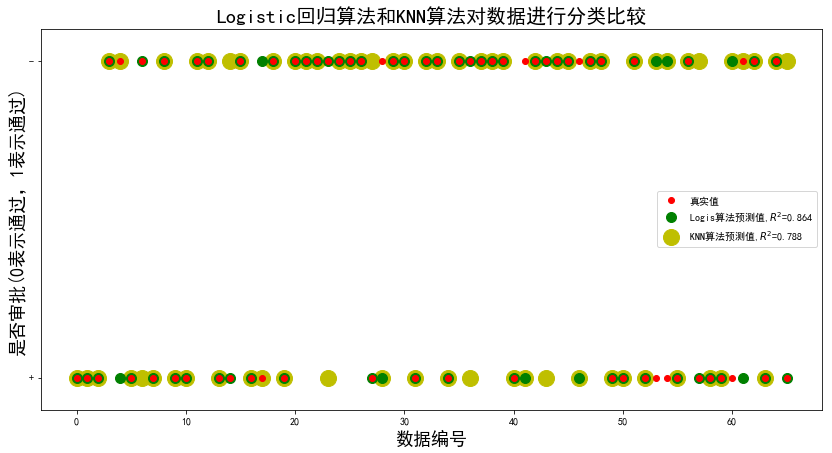

In [57]:
## 结果图像展示
## c. 图表展示
x_len = range(len(X_test))
plt.figure(figsize=(14,7), facecolor='w')
plt.ylim(-0.1,1.1)
plt.plot(x_len, Y_test, 'ro',markersize = 6, zorder=3, label=u'真实值')
plt.plot(x_len, lr_y_predict, 'go', markersize = 10, zorder=2, label=u'Logis算法预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.plot(x_len, knn_y_predict, 'yo', markersize = 16, zorder=1, label=u'KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'center right')
plt.xlabel(u'数据编号', fontsize=18)
plt.ylabel(u'是否审批(0表示通过，1表示通过)', fontsize=18)
plt.title(u'Logistic回归算法和KNN算法对数据进行分类比较', fontsize=20)
plt.show()

#自己练习

In [37]:
df = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],'data1': range(6),'data2':[1.0,2.0,3.0,4.0,5.0,6.0],'class':['A','B','C','A','B','C']})
print(df.info())
print(df)
df = pd.get_dummies(df)
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 4 columns):
class    6 non-null object
data1    6 non-null int64
data2    6 non-null float64
key      6 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 272.0+ bytes
None
  class  data1  data2 key
0     A      0    1.0   b
1     B      1    2.0   b
2     C      2    3.0   a
3     A      3    4.0   c
4     B      4    5.0   a
5     C      5    6.0   b
   data1  data2  class_A  class_B  class_C  key_a  key_b  key_c
0      0    1.0        1        0        0      0      1      0
1      1    2.0        0        1        0      0      1      0
2      2    3.0        0        0        1      1      0      0
3      3    4.0        1        0        0      0      0      1
4      4    5.0        0        1        0      1      0      0
5      5    6.0        0        0        1      0      1      0


In [11]:
import pandas as pd
def parse(v, l):
    return [1 if i == v else 0 for i in l]

A1 = ['a','a','b','b','a']
df = pd.DataFrame(A1,columns=['A'])

a1 = df['A']
print(a1)
result = []
for i in parse(a1, ('a', 'b')):
    result.append(i)


0    a
1    a
2    b
3    b
4    a
Name: A, dtype: object


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().